## Testing Polarization properties with Hourglass Morphology
- hourglass morphology
- injects turbulence in POS
- Bz (or LOS component) assume constant
- calculates Stokes observables

#### establish input parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# user parameters
# ===============================
n = 64                      # grid resolution
L = 0.5                     # box half-size
B0 = 1.0
I0 = 1.0

# LOS choice: 0=x, 1=y, 2=z
iaxis = 2

# Turbulence
turb_sigma = 0.25
corr_r = 0.9

# ===============================
# establish cartesian grid
# ===============================
x = np.linspace(-L, L, n)
y = np.linspace(-L, L, n)
z = np.linspace(-L, L, n)
X, Y, Z = np.meshgrid(x, y, z, indexing="ij")
R = np.sqrt(X**2 + Y**2)

In [2]:
# ===============================
# hourglass morphology
# ===============================
alpha = 4.0     # pinch strength of hourglass shape
beta  = 2.0     # vertical taper

Br = alpha * R * np.exp(-beta * Z**2)
Bz = 1.0 + alpha * np.exp(-beta * Z**2)

# Convert cylindrical to cartesian
Bx = Br * X / (R + 1e-12) # 1e-12 to avoid division by zero
By = Br * Y / (R + 1e-12)


In [3]:
# ===============================
# add turbulent perturbations
# ===============================
delta_theta = np.zeros((n, n, n))

# axes orthogonal to LOS
axes = [0, 1, 2]
axes.remove(iaxis)
i1, i2 = axes

for i in range(n):
    for j in range(n):
        val = np.random.normal(scale=turb_sigma)
        for k in range(n):
            idx = [0, 0, 0]
            idx[iaxis] = k
            idx[i1] = i
            idx[i2] = j
            delta_theta[tuple(idx)] = val
            val = corr_r * val + np.random.normal(scale=turb_sigma * np.sqrt(1 - corr_r**2))

# perturb POS components
if iaxis == 0:      # LOS = x -- POS = y,z
    By_p =  By*np.cos(delta_theta) - Bz*np.sin(delta_theta)
    Bz_p =  By*np.sin(delta_theta) + Bz*np.cos(delta_theta)
    Bx_p =  Bx
elif iaxis == 1:    # LOS = y -- POS = x,z
    Bx_p =  Bx*np.cos(delta_theta) - Bz*np.sin(delta_theta)
    Bz_p =  Bx*np.sin(delta_theta) + Bz*np.cos(delta_theta)
    By_p =  By
else:               # LOS = z -- POS = x,y
    Bx_p =  Bx*np.cos(delta_theta) - By*np.sin(delta_theta)
    By_p =  Bx*np.sin(delta_theta) + By*np.cos(delta_theta)
    Bz_p =  Bz


In [4]:
# ===============================
# calculate stokes parameters
# ===============================
Bperp2 = Bx_p**2 + By_p**2
Btot2  = Bperp2 + Bz_p**2

cos2g = Bperp2 / (Btot2 + 1e-12)

# two ways of calculating q and u, one with Bz, one with cos2g, but result is the same:

# q = (By_p**2 - Bx_p**2) / (Bperp2 + 1e-12) * cos2g
# u = (2 * Bx_p * By_p) / (Bperp2 + 1e-12) * cos2g

q = (By_p**2 - Bx_p**2) / Btot2
u = (2 * Bx_p * By_p) / Btot2

Q = I0 * q
U = I0 * u



In [7]:
# ===============================
# integrate along LOS, calculate observables
# ===============================
Q_obs = Q.sum(axis=iaxis)
U_obs = U.sum(axis=iaxis)
I_obs = I0 * n

P_obs   = np.sqrt(Q_obs**2 + U_obs**2) / I_obs
phi_obs = 0.5 * np.arctan2(U_obs, Q_obs)
cos2g_LOS = (I0*cos2g).sum(axis=iaxis)/I0


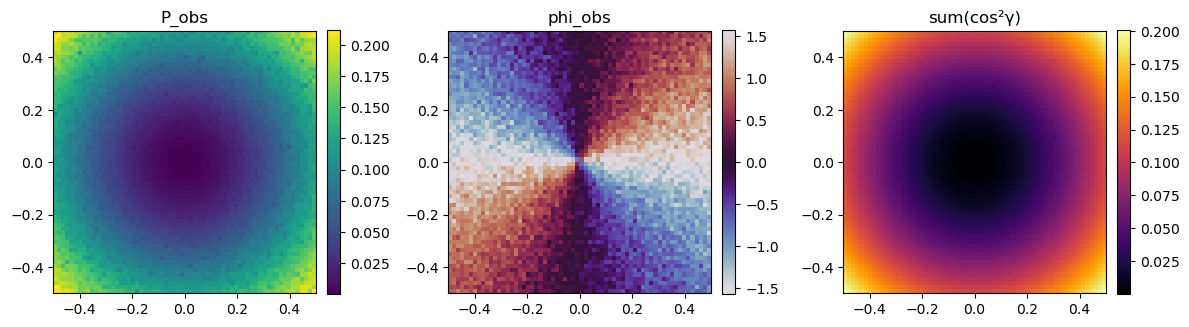

In [8]:
# ===============================
# plot observables to compare and check
# ===============================
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

extent = [-L, L, -L, L]

im0 = axs[0].imshow(P_obs.T, origin="lower", extent=extent, cmap="viridis")
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
axs[0].set_title("P_obs")

im1 = axs[1].imshow(phi_obs.T, origin="lower", extent=extent, cmap="twilight")
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
axs[1].set_title("phi_obs")

im2 = axs[2].imshow(cos2g[:,:,0], origin="lower",
                    extent=extent, cmap="inferno")
plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
axs[2].set_title("sum(cos²γ)")

plt.tight_layout()
plt.show()


### For cos2g vs. P:
- with turbulence, expect vertical scatter
- without turbulence, expect tight correlation

Text(0.5, 1.0, 'LOS-Summed cos²γ vs P')

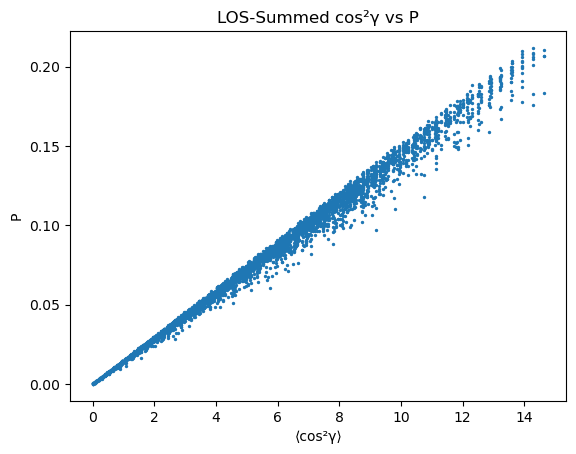

In [10]:
# ===============================
# plot cos2g vs P
# ===============================
plt.scatter(cos2g_LOS.flatten(), P_obs.flatten(), s=2, label='cos2g_LOS')
plt.xlabel("⟨cos²γ⟩")
plt.ylabel("P")
plt.title('LOS-Summed cos²γ vs P')


## Now test for varying turbulence

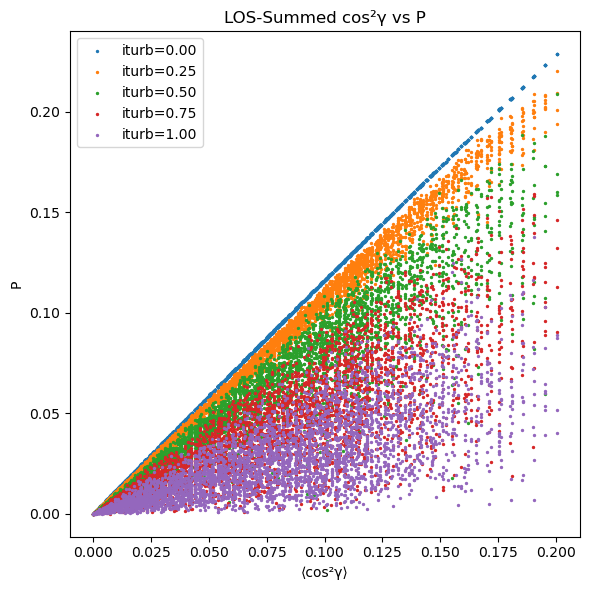

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def hourglass_turb_test(turb):
    # ===============================
    # USER PARAMETERS
    # ===============================
    n = 64                      # grid resolution
    L = 0.5                     # box half-size
    B0 = 1.0
    I0 = 1.0

    # LOS choice: 0=x, 1=y, 2=z
    iaxis = 2

    # Turbulence
    turb_sigma = turb
    corr_r = 0.9

    # ===============================
    # CARTESIAN GRID
    # ===============================
    x = np.linspace(-L, L, n)
    y = np.linspace(-L, L, n)
    z = np.linspace(-L, L, n)
    X, Y, Z = np.meshgrid(x, y, z, indexing="ij")

    R = np.sqrt(X**2 + Y**2)

    # ===============================
    # HOURGLASS FIELD (TOY MODEL)
    # ===============================
    alpha = 4.0     # pinch strength
    beta  = 2.0     # vertical taper

    Br = alpha * R * np.exp(-beta * Z**2)
    Bz = 1.0 + alpha * np.exp(-beta * Z**2)

    # Convert cylindrical → Cartesian
    Bx = Br * X / (R + 1e-12)
    By = Br * Y / (R + 1e-12)

    # ===============================
    # TURBULENCE (ROTATE POS FIELD)
    # ===============================
    delta_theta = np.zeros((n, n, n))

    # axes orthogonal to LOS
    axes = [0, 1, 2]
    axes.remove(iaxis)
    i1, i2 = axes

    for i in range(n):
        for j in range(n):
            val = np.random.normal(scale=turb_sigma)
            for k in range(n):
                idx = [0, 0, 0]
                idx[iaxis] = k
                idx[i1] = i
                idx[i2] = j
                delta_theta[tuple(idx)] = val
                val = corr_r * val + np.random.normal(
                    scale=turb_sigma * np.sqrt(1 - corr_r**2)
                )

    # Rotate POS components
    if iaxis == 0:      # LOS = x → POS = y,z
        By_p =  By*np.cos(delta_theta) - Bz*np.sin(delta_theta)
        Bz_p =  By*np.sin(delta_theta) + Bz*np.cos(delta_theta)
        Bx_p =  Bx
    elif iaxis == 1:    # LOS = y → POS = x,z
        Bx_p =  Bx*np.cos(delta_theta) - Bz*np.sin(delta_theta)
        Bz_p =  Bx*np.sin(delta_theta) + Bz*np.cos(delta_theta)
        By_p =  By
    else:               # LOS = z → POS = x,y
        Bx_p =  Bx*np.cos(delta_theta) - By*np.sin(delta_theta)
        By_p =  Bx*np.sin(delta_theta) + By*np.cos(delta_theta)
        Bz_p =  Bz

    # ===============================
    # STOKES PARAMETERS
    # ===============================
    Bperp2 = Bx_p**2 + By_p**2
    Btot2  = Bperp2 + Bz_p**2

    cos2g = Bperp2 / (Btot2 + 1e-12)

    q = (By_p**2 - Bx_p**2) / (Bperp2 + 1e-12) * cos2g
    u = (2 * Bx_p * By_p) / (Bperp2 + 1e-12) * cos2g

    Q = I0 * q
    U = I0 * u

    # ===============================
    # LOS INTEGRATION
    # ===============================
    Q_obs = Q.sum(axis=iaxis)
    U_obs = U.sum(axis=iaxis)
    I_obs = I0 * n

    P_obs   = np.sqrt(Q_obs**2 + U_obs**2) / I_obs
    phi_obs = 0.5 * np.arctan2(U_obs, Q_obs)
    # cos2g_LOS = (I0*cos2g).sum(axis=iaxis)/I0
    cos2g_LOS = cos2g[:,:,0] # take first slice of cos2g since it's the same along LOS

    P_complex   = Q_obs + 1j * U_obs
    P_max       = I0*cos2g_LOS
    P_coherence = np.abs(P_complex) / (P_max + 1e-12)

    # ===============================
    # PLOTS
    # ===============================

    plt.scatter(cos2g_LOS.flatten(), P_obs.flatten(), s=2, label='iturb={:.2f}'.format(turb))
    plt.xlabel("⟨cos²γ⟩")
    plt.ylabel("P")
    plt.title('LOS-Summed cos²γ vs P')

plt.figure(figsize=(6,6))
for iturb in np.linspace(0, 1, 5):
    hourglass_turb_test(turb=iturb)
plt.legend()
plt.tight_layout()


In [ ]:
# P_complex   = Q_obs + 1j * U_obs
# P_max       = I0*cos2g_LOS
# P_coherence = np.abs(P_complex) / (P_max + 1e-12)

# fig, axs = plt.subplots(2, 2, figsize=(5, 5))

# axs[0,0].imshow(P_obs.T, origin="lower")
# axs[0,0].set_title("Observed P")

# axs[0,1].imshow(cos2g_LOS.T, origin="lower")
# axs[0,1].set_title("⟨cos²γ⟩")

# axs[1,0].imshow(P_coherence.T, origin="lower")
# axs[1,0].set_title("Coherence")

# axs[1,1].imshow((P_obs / cos2g_LOS).T, origin="lower")
# axs[1,1].set_title("P / ⟨cos²γ⟩")

# plt.tight_layout()


# phi = 0.5 * np.arctan2(U, Q)

# phi_mean = np.mean(phi, axis=iaxis)
# phi_disp = np.sqrt(np.mean((phi - phi_mean[...,None])**2, axis=iaxis))

# plt.scatter(phi_disp.flatten(), P_coherence.flatten(), s=2)
# plt.xlabel(r"Dispersion in $\phi$")
# plt.ylabel("Coherence in P")
